# Library

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.activations import relu

# from google.colab import drive
# drive.mount('/content/gdrive')

# %cd /content/gdrive/MyDrive/Colab Notebooks/Google Solution Challenge/Model

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Google Solution Challenge/Model


# Data Setting

## Flower Photo Data

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


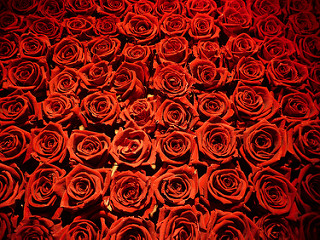

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

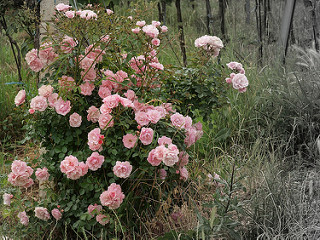

In [ ]:
PIL.Image.open(str(roses[1]))

# Create Data-set

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

## Flower Photo Data

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## MNIST Data

In [ ]:
mnist_data = mnist
(x_train, y_train), (x_test, y_test) = mnist_data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
x_train.shape

(50000, 28, 28)

# Model Define

## AlexNet


In [ ]:
def AlexNet(input_layer=Input(shape=(227,227,3)), num_class=5, base_channel=96, optimizer='adam', loss=SparseCategoricalCrossentropy):
  modules = []
  modules += [input_layer]
  # Conv_Block_1
  modules += [layers.Conv2D(base_channel,11,strides=4,activation='relu',use_bias=False)]
  modules += [layers.MaxPooling2D(pool_size=3,strides=2)]
  # Conv_Block_2
  modules += [layers.Conv2D(256,5,strides=1,padding='same',activation='relu',use_bias=False)]
  modules += [layers.MaxPooling2D(pool_size=3,strides=2)]
  # Conv_Block_3
  modules += [layers.Conv2D(384,3,strides=1,padding='same',activation='relu',use_bias=False)]
  # Conv_Block_4]
  modules += [layers.Conv2D(384,3,strides=1,padding='same',activation='relu',use_bias=False)]
  # Conv_Block_5
  modules += [layers.Conv2D(256,3,strides=1,padding='same',activation='relu',use_bias=False)]
  modules += [layers.MaxPooling2D(pool_size=3,strides=2)]
  
  model = Sequential(modules)
  # Fully_Connected_layer
  model.add(layers.Flatten())
  model.add(layers.Dense(4096,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(4096,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(num_class))

  # Model Compiling
  model.compile(optimizer=optimizer,
                      loss=loss(from_logits=True),
                      metrics=['accuracy'])
  return model

## VGGNet

In [ ]:
def VGGNet(input_layer=Input(shape=(224,224,3)), num_layer=[2,2,3,3,3], num_class=5, base_channel=64, optimizer='adam', loss=SparseCategoricalCrossentropy):
  modules = []
  modules += [input_layer]
  # Conv_Block_1
  modules += [layers.Conv2D(base_channel,3,padding='same',activation='relu',use_bias=False) for _ in range(num_layer[0])]
  modules += [layers.MaxPooling2D(pool_size=2,strides=2, padding='same')]
  # Conv_Block_2
  modules += [layers.Conv2D(base_channel*2,3,padding='same',activation='relu',use_bias=False) for _ in range(num_layer[1])]
  modules += [layers.MaxPooling2D(pool_size=2,strides=2, padding='same')]
  # Conv_Block_3
  modules += [layers.Conv2D(base_channel*4,3,padding='same',activation='relu',use_bias=False) for _ in range(num_layer[2])]
  modules += [layers.MaxPooling2D(pool_size=2,strides=2, padding='same')]
  # Conv_Block_4]
  modules += [layers.Conv2D(base_channel*8,3,padding='same',activation='relu',use_bias=False) for _ in range(num_layer[3])]
  modules += [layers.MaxPooling2D(pool_size=2,strides=2, padding='same')]
  # Conv_Block_5
  modules += [layers.Conv2D(base_channel*8,3,padding='same',activation='relu',use_bias=False) for _ in range(num_layer[4])]
  modules += [layers.MaxPooling2D(pool_size=2,strides=2, padding='same')]
  
  model = Sequential(modules)
  # Fully_Connected_layer
  model.add(layers.Flatten())
  model.add(layers.Dense(4096,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(4096,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(num_class))

  # Model Compiling
  model.compile(optimizer=optimizer,
                      loss=loss(from_logits=True),
                      metrics=['accuracy'])
  return model

## ResNet

In [ ]:
def ConvBN(Input_layer, out_channel, kernel_size, padding, strides):
  x = Input_layer
  x = layers.Conv2D(out_channel,kernel_size,padding=padding,strides=strides,use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  return relu(x)

def Basic(input_layer, out_channel, down=False):
  x = input_layer
  out = x
  strides = 2 if down else 1
  
  x = ConvBN(x, out_channel, kernel_size=3, padding='same', strides=strides)
  x = layers.Conv2D(out_channel,3,padding='same',use_bias=False)(x)
  x = layers.BatchNormalization()(x)

  if down:
    out = layers.Conv2D(out_channel,1,strides=strides,use_bias=False)(out)
    out = layers.BatchNormalization()(out)
  
  return relu(Add()([x, out]))

def Bottleneck(input_layer, in_channel, mid_channel, out_channel, down=False):
  x = input_layer
  out = x
  strides = 2 if down else 1

  x = ConvBN(x, mid_channel, kernel_size=1, padding='valid', strides=strides)
  x = ConvBN(x, mid_channel, kernel_size=3, padding='same', strides=1)
  x = layers.Conv2D(out_channel,1,use_bias=False)(x)
  x = layers.BatchNormalization()(x)

  if down:
    out = layers.Conv2D(out_channel,1,strides=strides,use_bias=False)(out)
    out = layers.BatchNormalization()(out)
  
  if in_channel != out_channel and not down:
    out = layers.Conv2D(out_channel,1,strides=strides,use_bias=False)(out)
    out = layers.BatchNormalization()(out)

  return relu(Add()([x, out]))

def ResNet(input_layer=Input(shape=(224,224,3)), block=Bottleneck, num_layer=[3,4,6,3], num_class=5, out_channel=64, optimizer='adam', loss=SparseCategoricalCrossentropy):
  x = input_layer
  x = ConvBN(x, out_channel, kernel_size=7, padding='same', strides=2)
  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  # Cov_Blocks
  if block is Basic:
    for _ in range(num_layer[0]):
      x = Basic(x, out_channel)
    
    x = Basic(x, out_channel*2, down=True)
    for _ in range(num_layer[1]-1):
      x = Basic(x, out_channel*2)

    x = Basic(x, out_channel*4, down=True)
    for _ in range(num_layer[2]-1):
      x = Basic(x, out_channel*4)
    
    x = Basic(x, out_channel*8, down=True)
    for _ in range(num_layer[3]-1):
      x = Basic(x, out_channel*8)
  elif block is Bottleneck:
    x = Bottleneck(x, out_channel, out_channel, out_channel*4)
    for _ in range(num_layer[0]-1):
      x = Bottleneck(x, out_channel*4, out_channel, out_channel*4)
    
    x = Bottleneck(x, out_channel*4, out_channel*2, out_channel*8, down=True)
    for _ in range(num_layer[1]-1):
      x = Bottleneck(x, out_channel*8, out_channel*2, out_channel*8)
    
    x = Bottleneck(x, out_channel*8, out_channel*4, out_channel*16, down=True)
    for _ in range(num_layer[2]-1):
      x = Bottleneck(x, out_channel*16, out_channel*4, out_channel*16)

    x = Bottleneck(x, out_channel*16, out_channel*8, out_channel*32, down=True)
    for _ in range(num_layer[3]-1):
      x = Bottleneck(x, out_channel*32, out_channel*8, out_channel*32)    

  # Fully_Connected_layer
  x = layers.AveragePooling2D(padding='same')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(num_class)(x)

  model = Model(
      inputs=input_layer,
      outputs=x
  )

  # Model Compiling
  model.compile(optimizer=optimizer,
                      loss=loss(from_logits=True),
                      metrics=['accuracy'])
  return model

# Model 생성

In [ ]:
model = VGGNet(input_layer=Input(shape=(28,28,1)), num_class=10,)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        576       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36864     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73728     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                    

# 모델 훈련

## Training with flower photo data

In [ ]:
# epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
# model.save('./my_model')

## Training with MNIST data

In [ ]:
epochs = 10
batch_size = 64
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

Epoch 1/10
782/782 [==============================] - 5798s 7s/step - loss: 1.6031 - accuracy: 0.3797 - val_loss: 0.5302 - val_accuracy: 0.8244
Epoch 2/10
782/782 [==============================] - 5739s 7s/step - loss: 0.2342 - accuracy: 0.9428 - val_loss: 0.1027 - val_accuracy: 0.9764
Epoch 3/10
150/782 [====>.........................] - ETA: 1:14:46 - loss: 0.1108 - accuracy: 0.9742

In [ ]:
model.evaluate(
    x_test,
    y_test,
    batch_size=batch_size
)

In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6094176394639826067
xla_global_id: -1
]


In [3]:
import torch
print(torch.cuda.is_available())

OSError: [WinError 182] 운영 체제가 %1을(를) 실행할 수 없습니다. Error loading "D:\anaconda\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.